# Randomized Benchmarking with Q# and Python

**NB**: This notebook requires additional packages to analyze randomized benchmarking results offline. Dependencies for this sample can be installed as a new virtual environment by using `conda`:

```sh
conda env create -f environment.yml
conda activate randomized-benchmarking
```

$\newcommand{\Tr}{\operatorname{Tr}}$

## Abstract ##

This sample demonstrates how to use Q# and Python together to simulate randomized benchmarking, a common protocol for characterizing quantum systems. In particular, this sample shows how to generate random sequences within your quantum program, analyze the results offline, and how to use online statistical inference to adaptively choose RB experiments.

> **NOTE**: This sample is somewhat more advanced than most, and assumes familiarity with open quantum systems as well as some statistics knowledge.
> If you would like a refresher on these topics, please check out the [**process-tomography**](../process-tomography/README.md) and [**phase-estimation**](../phase-estimation/README.md) samples.

## Preamble ##

We can enable Q# support in Python by importing the `qsharp` package.

In [1]:
import qsharp
import qsharp.experimental
qsharp.experimental.enable_noisy_simulation()

Preparing Q# environment...
.

We'll also be using numerics in this sample, so we import NumPy as well.

In [2]:
import numpy as np

Next, we import plotting support and the QuTiP library, since these will be helpful to us in manipulating the quantum objects returned by the quantum process tomography functionality that we call later.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import qutip as qt
qt.settings.colorblind_safe = True

Finally, to analyze randomized benchmarking results offline, we'll be using the [QInfer](http://qinfer.org) library, so we go on and import it here.

In [5]:
import qinfer as qi

## Randomized Benchmarking ##

Consider the problem of learning the noise acting on an $n$-qubit register. Without any prior assumptions, density operators on that register are matrices of $2^n \times 2^n$ complex numbers, such that noise channels acting on those density operators can be expressed as $4^n \times 4^n$ complex numbers. Even for a two-qubit register, it takes 256 complex numbers to write down a noise process acting on that register.

This quickly gets out of hand, such that using tomography to learn noise quickly becomes infeasible as systems grow in size. Moreover, process tomography rests on the critical assumption that state preparation and measurement (also known as "_SPAM_") are either perfect, or at least only subject to noise that itself is fully characterized. If this assumption is violated, SPAM errors can be conflated with the noise being estimated and vice versa.

One way to solve this is to use a technique known as _randomized benchmarking_, which uses a total of three real numbers to parameterize noise models instead of a tomographically complete description. By choosing sequences of gates of different lengths, randomized benchmarking can also deal with state preparation and measurement errors — errors due to gates grow with sequence lengths, while state preparation and measurement errors appear as constant offsets.

> **NOTE**: Though randomized benchmarking is works well for larger systems, for simplicitly this sample considers the single-qubit case.

### Sequence generation

Concretely, randomized benchmarking works by randomly choosing sequences of _Clifford operations_, those operations that map Pauli operations to other Pauli operations. In Q#, we can draw random elements of the single-qubit Clifford group by using the `DrawRandomSingleQubitClifford` operation.

> **💡 TIP**: The `%%qsharp` magic command tells IPython to treat that cell as Q# and to pass it to the Q# compiler, adding any new operations as Python variables.
> For more info, see the [Python interoperability sample](../../interoperability/python/).

In [6]:
%%qsharp
open Microsoft.Quantum.Arrays;
open Microsoft.Quantum.Random;
open Microsoft.Quantum.Synthesis;

operation DrawRandomSingleQubitRBSequence(nOperators : Int) : SingleQubitClifford[] {
    return DrawMany(DrawRandomSingleQubitClifford, nOperators, ());
}

In [7]:
DrawRandomSingleQubitRBSequence.simulate(nOperators=10)

[(0, 0, 1, 4),
 (0, 3, 1, 0),
 (1, 0, 0, 6),
 (2, 1, 1, 7),
 (2, 0, 1, 6),
 (0, 0, 0, 4),
 (0, 0, 1, 1),
 (2, 1, 1, 4),
 (0, 3, 0, 5),
 (1, 1, 0, 1)]

Each of the tuples in the above list represents a different Clifford operation, using the notation defined by the [`Microsoft.Quantum.Synthesis.SingleQubitClifford` user-defined type](https://docs.microsoft.com/qsharp/api/qsharp/microsoft.quantum.synthesis.singlequbitclifford).

> **📝 NOTE**: In randomized benchmarking, the term "sequence length" generally refers to the number of distinct Clifford operations performed in a given sequence. For instance, the tuple `(0, 1, 1, 0)` refers to the operation `BoundCA([X, S])`. For more details, see the documentation for the [`Apply1C` operation](https://docs.microsoft.com/qsharp/api/qsharp/microsoft.quantum.synthesis.apply1c) and the [`BoundCA` function](https://docs.microsoft.com/qsharp/api/qsharp/microsoft.quantum.canon.boundca).

In practice, however, randomized benchmarking requires that each different sequence multiplies to identity (written as the tuple `(0, 0, 0, 0)`), but this isn't true in general for the sequences chosen by the `DrawRandomSingleQubitRBSequence` that we defined above.

In [8]:
%%qsharp

operation CheckThatRandomSequenceMultipliesToIdentity(nOperators : Int) : Unit {
    let seq = DrawRandomSingleQubitRBSequence(nOperators);

    // Fold uses a function representing a binary operator to reduce
    // a Q# array to a single value. In this case, we use the FlippedCall
    // function below to implement the opposite product 𝑎 ×ₒₚ 𝑏 ≔ 𝑏 × 𝑎.
    // This allows us to multiply a sequence "backwards," since the matrix
    // product 𝐵𝐴 represents applying the operation A and then the operation B.
    let product = Fold(FlippedCall(Times1C, _, _), Identity1C(), seq);
    
    // At this point, we check if the product was the identity (0, 0, 0, 0),
    // and if not, then we can report the actual product.
    EqualityFact1C(Identity1C(), product, "Random sequence did not multiply to identity.");
}
    
function FlippedCall<'TLeft, 'TRight, 'TOutput>(
    fn : (('TLeft, 'TRight) -> 'TOutput),
    right : 'TRight,
    left : 'TLeft
)
: 'TOutput {
    return fn(left, right);
}

In [9]:
CheckThatRandomSequenceMultipliesToIdentity.simulate(nOperators=10)

Source,Callable
(notebook),CheckThatRandomSequenceMultipliesToIdentity


Random sequence did not multiply to identity.
	Expected:	SingleQubitClifford((1, 0, 1, 2))
	Actual:	SingleQubitClifford((0, 0, 0, 0))


We can modify the definition of DrawRandomSingleQubitRBSequence to correctly generate identity sequences by drawing one less Clifford operator and then appending the inverse of the all the other operations:

In [10]:
%%qsharp

operation DrawRandomSingleQubitRBSequence(nOperators : Int) : SingleQubitClifford[] {
    let root = DrawMany(DrawRandomSingleQubitClifford, nOperators - 1, ());
    let product = Fold(FlippedCall(Times1C, _, _), Identity1C(), root);
    return root + [Inverse1C(product)];
}

With this new definition in place, we can verify that our random sequence generation returns identity sequences.

In [11]:
CheckThatRandomSequenceMultipliesToIdentity.simulate(nOperators=10)

()

### RB measurements

Now that we have an operation that can randomly generate sequences that do nothing on an ideal quantum device, the core insight behind randomized benchmarking is that if we run random no-op programs on a noisy device, it's easy to see when we have an error. That is, if we prepare $\left|{0}\right\rangle$ and observe anything other than `Zero` when measuring in the $Z$-basis at the end, we can conclude that we saw at least one error.

In [12]:
%%qsharp
open Microsoft.Quantum.Measurement;

operation MeasureSingleQubitRBSequence(nOperators : Int) : Result {
    use q = Qubit();
    let ops = DrawRandomSingleQubitRBSequence(nOperators);
    for op in ops {
        // The Apply1C operation takes a single-qubit Clifford operator
        // and applies it as an operation.
        Apply1C(op, q);
    }
    return MResetZ(q);
}

Indeed, when we simulate how this protocol would work on an ideal device using the full-state simulator, we see that we always get `Zero` back.

In [13]:
sum(MeasureSingleQubitRBSequence.simulate(nOperators=10) for _ in range(50))

0

In general, randomized benchmarking requires us to draw a new sequence for each measurement [arXiv:1404.5275](https://arxiv.org/abs/1404.5275); though some generalizations exist that relax this limitation ([arXiv:1802.00401](https://arxiv.org/abs/1802.00401)), they require more sophisticated statistical analysis such that we focus on randomized benchmarking as originally presented here.

To that end, to collect multiple "shots" of RB, we can't pick a sequence then measure it many times, but must include a call to our sequence generation operation in our loop. Doing so, we can estimate the probability with which sequences of a given length correctly produce a result of `Zero` at the end. This probability is often called the "_survival probability_."

In [14]:
%%qsharp

operation MeasureSingleQubitRBSequenceLength(nOperators : Int, nSequences : Int) : Int {
    mutable nUp = 0;
    for idxSequence in 1..nSequences {
        set nUp += MeasureSingleQubitRBSequence(nOperators) == Zero ? 1 | 0;
    }
    return nUp;
}

In [15]:
MeasureSingleQubitRBSequenceLength.simulate(nOperators=10, nSequences=100) / 100

1.0

As expected, the survival probability for a system without noise is 100%.

### Noise models for RB

Of course, we want to use randomized benchmarking to study how imperfect devices are affected by noise, so let's switch from using the full-state simulator to the open systems simulator provided with the Quantum Development Kit. To do so, we'll need to provide a _noise model_ that describes the noise we want to simulate.

> **TIP**: For a refresher on open systems concepts, including channels and density operators, check out https://github.com/microsoft/qsharp-runtime/blob/main/documentation/examples/open-systems-concepts.ipynb.

We start by asking the `qsharp` package for an ideal noise model, representing the case of a noiseless device. Then, we can fill in each part of the noise model with channels that we want to use to simulate each different operation.

In [16]:
noise_model = qsharp.experimental.get_noise_model_by_name('ideal')

Using the [QuTiP library](https://qutip.org/), we can randomly choose channels from the space of all possible channels with [the `rand_super_bcsz` function](https://qutip.org/docs/latest/apidoc/functions.html#qutip.random_objects.rand_super_bcsz).

In [17]:
qt.rand_super_bcsz()

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = (4, 4), type = super, isherm = False
Qobj data =
[[ 0.64274359-1.97866896e-18j -0.00961122-1.81933491e-02j
  -0.00961122+1.81933491e-02j  0.48613981-1.45825192e-16j]
 [-0.06423074+5.00102431e-02j  0.02094879-1.42485396e-01j
   0.03487766-5.34334994e-03j -0.23811642+2.67785200e-01j]
 [-0.06423074-5.00102431e-02j  0.03487766+5.34334994e-03j
   0.02094879+1.42485396e-01j -0.23811642-2.67785200e-01j]
 [ 0.35725641+3.52365706e-19j  0.00961122+1.81933491e-02j
   0.00961122-1.81933491e-02j  0.51386019-1.51544359e-16j]]

In general, these channels will have very poor fidelity, so to get a more realistic noise model we can mix channels drawn from the `rand_super_bcsz` function with channels describing the ideal action of each operation.

In [18]:
qt.average_gate_fidelity(qt.rand_super_bcsz())

0.5633237067923123

In [19]:
def mix_with_bcsz(ideal, pr_success=0.99):
    return pr_success * qt.to_super(ideal) + (1 - pr_success) * qt.rand_super_bcsz()

In [20]:
qt.average_gate_fidelity(mix_with_bcsz(qt.qeye(2)))

0.9938196481906818

Let's use this to fill out our noise model, making sure to define what happens for each Pauli and Clifford operation.

In [21]:
noise_model['x'] = mix_with_bcsz(qt.sigmax())
noise_model['y'] = mix_with_bcsz(qt.sigmay())
noise_model['z'] = mix_with_bcsz(qt.sigmaz())
noise_model['h'] = mix_with_bcsz(qt.qip.operations.hadamard_transform())
noise_model['s'] = mix_with_bcsz(qt.qip.operations.phasegate(np.pi / 2))
noise_model['s_adj'] = mix_with_bcsz(qt.qip.operations.phasegate(-np.pi / 2))

In [22]:
qsharp.experimental.set_noise_model(noise_model)

Running our RB measurements using this noise model, we note that we no longer get that every sequence at a given length returns `Zero`.

In [23]:
MeasureSingleQubitRBSequenceLength.simulate_noise(nOperators=10, nSequences=100)

85

Indeed, if we plot the number of sequence measurements that correctly return `Zero` at each length, we can confirm that as we run longer and longer sequences, the effects of the noise increase.

In [24]:
seq_lens = np.logspace(np.log10(3), np.log10(200), 21).astype(int)
seq_lens

array([  3,   3,   4,   5,   6,   8,  10,  13,  16,  19,  24,  30,  37,
        45,  56,  69,  86, 106, 131, 162, 200])

> **📝 NOTE**: We use exponentially spaced sequences here since longer sequences tell us more about the fidelity (that is, longer sequences depend more strongly on $p$) than shorter sequences. This allows us to both use short sequences to learn $A$ and $B$, as well as longer sequences to learn $p$. We'll see a better approach to choosing sequence lengths later when we see how to include adaptivity in our randomized benchmarking program.

In [25]:
est_pr_survival = [
    MeasureSingleQubitRBSequenceLength.simulate_noise(nOperators=seq_len, nSequences=200) / 200
    for seq_len in seq_lens
]

Text(0,0.5,'Estimated survival probability')

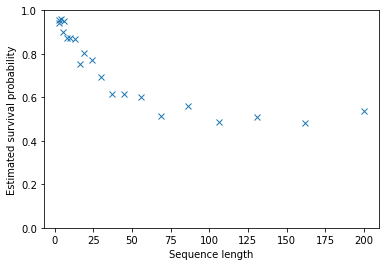

In [26]:
plt.plot(seq_lens, est_pr_survival, 'x')
plt.ylim(0, 1)
plt.xlabel('Sequence length')
plt.ylabel('Estimated survival probability')

By learning the rate at which the survival probability decays to 0.5 (all measurements are just random), we can learn how strongly noise has affected our quantum device. In the next part of this sample, we look at ways we can learn this rate.

## Inferring noise strengths from RB results

### Curve fitting

Following the derivation of [arXiv:1109.6887](https://arxiv.org/abs/1109.6887), the average survival probability for a sequence of length $m$ is given by
$$
    \Pr(\text{survive} | m; A, B, p) = Ap^m + B,
$$
where $A$, $B$, and $p$ parameterize the strength of the noise in terms of the initial state $\rho$, the final measurement $E$, and the average gate fidelity $F(\Lambda)$ over the noise in each different operation in the Clifford group,
$$
\begin{aligned}
    p & = \frac{dF(\Lambda) - 1}{d - 1} \\
    A & = \Tr(E\Lambda(\rho - 𝟙 / d)) \\
    B & = \Tr(E\Lambda(𝟙 / d)),
\end{aligned}
$$
and where $d$ is the dimension of the Hilbert space that our state is defined on ($d = 2$ for a single qubit, as in this case).

Effectively, $Ap^m + B$ acts as a model we can use to learn $p$, $A$, and $B$ from the results of measuring random RB sequences.

To see how this works, let's use _curve fitting_ to find $p$, $A$, and $B$

> **⚠ WARNING**: Curve fitting RB data can introduce some subtle errors into your estimate — we'll see more rigorous ways of learning $p$, $A$, and $B$ later in the sample.

We can start by defining a Q# operation that runs an entire nonadaptive RB experiment.

In [27]:
%%qsharp
open Microsoft.Quantum.Convert;

operation RunRBExperiment(sequenceLengths : Int[], nSequencesPerLength : Int) : Double[] {
    mutable results = [];
    for length in sequenceLengths {
        let survivalAtLength = MeasureSingleQubitRBSequenceLength(length, nSequencesPerLength);
        set results += [IntAsDouble(survivalAtLength) / IntAsDouble(nSequencesPerLength)];
    }
    return results;
}

In [28]:
est_pr_survival = RunRBExperiment.simulate_noise(sequenceLengths=seq_lens, nSequencesPerLength=200)

Text(0,0.5,'Estimated survival probability')

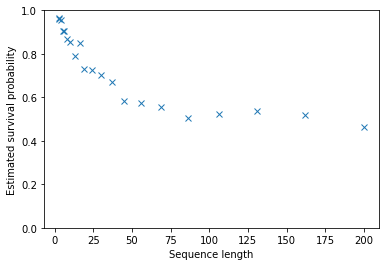

In [29]:
plt.plot(seq_lens, est_pr_survival, 'x')
plt.ylim(0, 1)
plt.xlabel('Sequence length')
plt.ylabel('Estimated survival probability')

Once we have these results, we can use the `curve_fit` function to roughly estimate $p$, $A$, and $B$.

In [30]:
from scipy.optimize import curve_fit

In [31]:
model = (lambda m, p, A, B: A * p**m + B)
p_opt, p_cov = curve_fit(
    model,
    seq_lens,
    est_pr_survival,
    [0.95, 0.5, 0.5]
)

In [32]:
p_opt

array([0.96707933, 0.50036617, 0.50051959])

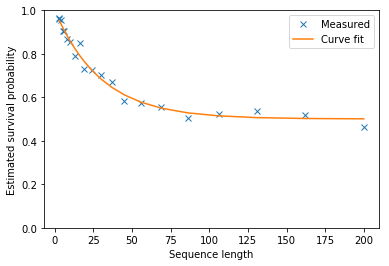

In [33]:
plt.plot(seq_lens, est_pr_survival, 'x', label='Measured')
plt.plot(seq_lens, model(seq_lens, *p_opt), label='Curve fit')
plt.plot()
plt.ylim(0, 1)
plt.xlabel('Sequence length')
plt.ylabel('Estimated survival probability')
plt.legend()

While this gives us qualitative agreement with our RB data, there are two problems left by using curve fitting:

- The curve that best minimizes residual errors may or may not be the curve that gives us the most accurate value for $p$.
- Because all estimation is done in post-processing, we cannot use measurements online to choose ideal sequence lengths.

Thankfully, we can use Q# to solve both of these problems.

### Particle filtering

First, let's see how we can improve our estimation given RB results. Essentially, curve fitting answers the question of what parameters to a model minimize the distance between the model and the observed data (in particular, where "distance" is formalised as "mean squared error"). This is a subtlely different question than that of what parameters minimize the average error with respect to the true parameters; the former is concerned with distance between datasets, while the latter is concerned with the distance between model parameters.

These two questions coincide when every data point follows the same normal distribution (homoskedastic normally distributed errors), but since that does not hold in randomized benchmarking, we'll turn to Bayesian inference instead. In particular, we use a technique known as _particle filtering_, where each different hypothesis about $p$, $A$, and $B$ is represented by a weight $w_i$ associated with that hypothesis,
$$
    \Pr(p, A, B) \approx \sum_i w_i \delta(p - p_i) \delta(A - A_i) \delta(B - B_i).
$$
This allows us to write down everything we currently know about our parameters in terms of a list $\{(w_i, p_i, A_i, B_i)\}_{i=0}^{N - 1}$.

Using the QInfer library to implement particle filtering, we can go on and analyze the results above.

In [34]:
import pandas as pd

In [35]:
df = pd.DataFrame({'m': seq_lens, 'counts': 100 * np.array(est_pr_survival), 'n_shots': 100, 'interleaved': False})

In [36]:
est, cov, extra = qi.simple_est_rb(data=df.to_records(), return_all=True)
est, cov

(array([0.96322122, 0.47139433, 0.50785123]),
 array([[ 5.69897321e-05,  1.19073499e-04, -1.25189476e-04],
        [ 1.19073499e-04,  7.21586405e-04, -6.44004656e-04],
        [-1.25189476e-04, -6.44004656e-04,  6.39871885e-04]]))

Using the data we get back from QInfer, we can plot our uncertianty about $p$:

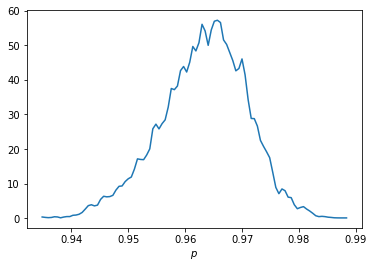

In [37]:
extra['updater'].plot_posterior_marginal(idx_param=0)

Because the particle filter approximation captures our entire state of knowledge about $p$, we can even use that knowledge to make adaptive decisions about what sequence lengths to measure. As shown in [arXiv:1404.5275](https://arxiv.org/abs/1404.5275), the optimal sequence length to measure is approximately $m = 1 / (1 - F)$. To use that with a statistical inference engine written in Python, though, we'd need to make a round trip back and forth between our quantum device and our Python host with every single measurement — this is clearly not practical in general. Fortunately, the particle filtering algorithm is simple enough we can actually write it directly in Q#!

### Adaptive sequence lengths in Q\#

In order to perform the statistical inference we need to choose sequence lenghts adaptively, we need to define our RB model in terms of Q# functions:

In [38]:
%%qsharp

function RBLikelihood(datum : Result, modelparams : Double[], seqLength : Int) : Double {
    let p = modelparams[0];
    let A = modelparams[1];
    let B = modelparams[2];
    let pr0 = A * p^IntAsDouble(seqLength) + B;
    return datum == Zero ? pr0 | 1.0 - pr0;
}

function IsRbModelValid(modelparams : Double[]) : Bool {
    let p = modelparams[0];
    let A = modelparams[1];
    let B = modelparams[2];
    
    return 0.0 <= p and
            p <= 1.0 and
            0.0 <= A and
            A <= 1.0 and
            0.0 <= B and
            B <= 1.0 and
            A + B <= 1.0 and
            A * p + B <= 1.0;
}

function RBModel()
: (
    ((Result, Double[], Int) -> Double),
    (Double[] -> Bool)
) {
    return (RBLikelihood, IsRbModelValid);
}

Next, we define our prior distribution over $p$, $A$, and $B$, representing what we know about our system before we start. Here, we'll assume that $p \ge 90\%$, as we probably think our device has small enough noise for RB to be interesting in the first place!

In [39]:
%%qsharp
open Microsoft.Quantum.Math;

// We'll need to open the namespace containing functions and operations defined locally in this sample.
// For details on how the particle filtering algorithm is implemented in Q#,
// see Inference.qs and Math.qs in this folder.
open Microsoft.Quantum.Samples;

operation DrawFromPrior() : Double[] {
    mutable model = [0.0, 0.0, 0.0];
    let dist = StandardNormalDistribution();

    repeat {
        // Assume p is at least 90%.
        let p = DrawRandomDouble(0.9, 1.0);
        let A = 0.5 + Sqrt(0.1^2.0) * dist::Sample();
        let B = 0.5 + Sqrt(0.1^2.0) * dist::Sample();

        set model = [p, A, B];
    }
    until IsRbModelValid(model);

    return model;
}

operation DrawInitialPrior(nParticles : Int) : SmcApproximation {
    return SmcApproximation(
        DrawMany(DrawFromPrior, nParticles, ()),
        ConstantArray(nParticles, 1.0 / IntAsDouble(nParticles))
    );
}

Once we have our RB model defined, we can use it to interactively estimate $p$, $A$, and $B$ and decide sequence lengths  on-the-fly.

In [40]:
%%qsharp
open Microsoft.Quantum.Samples;

operation RunAdaptiveRBExperiment(nParticles : Int, nShots : Int) : (Double[], Double[][]) {
    let dim = 2.0; // We're  working with a single qubit, so 𝑑 = 2.

    Message("starting with initial prior...");
    mutable dist = DrawInitialPrior(nParticles);
    Message("...done.");

    let model = RBModel();
    let options = DefaultSmcOptions();

    for idxShot in 1..nShots {
        Message($"Starting shot {idxShot}...");
        let currentMean = Mean(dist);
        let estF = 1.0 - (1.0 - currentMean[0]) * (dim - 1.0) / dim;
        let seqLength = Ceiling(1.0 / (1.0 - estF));
        let survival = MeasureSingleQubitRBSequence(seqLength);
        Message($"Survival at length {seqLength}: {survival}");
        set dist = Update(dist, survival, seqLength, model, options);
    }

    return (Mean(dist), Cov(dist));
}

In [41]:
est_online, cov_online = RunAdaptiveRBExperiment.simulate_noise(nParticles=6000, nShots=100)

starting with initial prior...
...done.
Starting shot 1...
Survival at length 41: One
Starting shot 2...
Survival at length 36: Zero
Starting shot 3...
Survival at length 39: One
Starting shot 4...
Survival at length 35: One
Starting shot 5...
Survival at length 33: Zero
Starting shot 6...
Survival at length 35: One
Starting shot 7...
Survival at length 33: One
Starting shot 8...
Survival at length 32: Zero
Starting shot 9...
Survival at length 33: Zero
Starting shot 10...
Survival at length 34: Zero
Starting shot 11...
Survival at length 36: Zero
Starting shot 12...
Survival at length 38: One
Starting shot 13...
Survival at length 36: One
Starting shot 14...
Survival at length 34: Zero
Starting shot 15...
Survival at length 35: One
Starting shot 16...
Survival at length 34: Zero
Starting shot 17...
Survival at length 35: Zero
Starting shot 18...
Survival at length 36: Zero
Starting shot 19...
Survival at length 38: One
Starting shot 20...
Survival at length 36: Zero
Starting shot 21..

In [42]:
from scipy.linalg import sqrtm
est_err = sqrtm(cov_online)[0, 0]

In [43]:
print(f"𝑝 = {est_online[0]} ± {est_err} (online, 100 shots)")
print(f"𝑝 = {est[0]} ± {sqrtm(cov)[0, 0]} (offline, {100 * len(seq_lens)} shots)")

𝑝 = 0.9592917354099967 ± 0.019104917832180313 (online, 100 shots)
𝑝 = 0.9632212210431783 ± 0.006309852038514136 (offline, 2100 shots)


By implementing our sequence generation and statistical inference in Q#, we were able to learn our RB parameters using only 100 shots nearly as well as we did with 2100 shots when we chose sequence lengths non-adaptively.

## Epilogue

In [44]:
for component, version in sorted(qsharp.component_versions().items(), key=lambda x: x[0]):
    print(f"{component:20}{version}")

.NET Runtime        .NETCoreApp,Version=v3.1
Jupyter Core        1.5.0.0
experimental        {'simulators': {'features': ['DEFAULT'], 'name': 'Microsoft.Quantum.Experimental.Simulators', 'opt_level': '3', 'target': 'x86_64-pc-windows-msvc', 'version': '0.18.210728727-alpha'}}
iqsharp             1.0.0
qsharp              0.18.2109.162713


In [45]:
import sys
print(sys.version)

3.7.10 | packaged by conda-forge | (default, Sep 13 2021, 19:12:52) [MSC v.1916 64 bit (AMD64)]
